In [2]:
import hmf
from hmf import functional
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
import numpy as np
import scipy.integrate
import astropy
from astropy.cosmology import LambdaCDM, Planck18_arXiv_v2

In [3]:
z = 15 # Redshift value to plot
mmin = 8 # Minimum halo mass for HMF
mmax = 15 # Maximum halo mass for HMF
ABmax = 31.5 # Max magnitude JWST can see

cosmo = Planck18_arXiv_v2 # Define temporary cosmology for volume calculation
vol = cosmo.comoving_volume(z + 0.5).value - cosmo.comoving_volume(z - 0.5).value
tot_sky = 41253. # Total square degrees in the sky
survey_area = 0.05556 # Survey area in square degrees
num_gal = 1 # Minimum number of galaxies needed within the survey area

# Find number density that would be visible to JWST
nmin = tot_sky / vol / survey_area

# All HMFCalc fitting function models
fitting_models = ["Angulo","AnguloBound","Behroozi","Bhattacharya",\
              "Courtin","Crocce","Ishiyama","Jenkins",\
              "Manera","PS","Peacock","Pillepich","Reed03","Reed07","SMT",\
              "Tinker08","Tinker10","Warren","Watson","Watson_FoF"]

# Values for the stellar baryon fraction
# Rough estimate of 1/70 and extrapolation from Finkelstein
# sbf_vals = [1./70, 0.051 + 0.024 * (z - 4)]
sbf_vals = [0.018, 0.051 + 0.024 * (z - 4), 0.051 + 0.031 * (z - 4), 0.051 + 0.017 * (z - 4)]

# Calculating change in magnitude due to wavelength
# Uses 1505 and 1605 because values at 1500 and 1600 Å are not in the continuum data
w_original = 1500 + 5 # From the Song 2016 M*-MUV relation
w_new = 1600 + 5

# Load spectrum
data = np.loadtxt("erb2010_continuum.dat")
x = data[:,0]
y = data[:,1] * x**2 / 3.e18

# Shift luminosity using spectrum assumption
shift = 2.5 * np.log10(y[x==w_original]/y[x==w_new])

C:\Users\chris\Anaconda3\lib\site-packages\hmf\mass_function\integrate_hmf.py:68: RuntimeWarning: divide by zero encountered in log
  mf_func = _spline(np.log(m), np.log(dndlnm), k=1)
C:\Users\chris\Anaconda3\lib\site-packages\hmf\mass_function\integrate_hmf.py:68: RuntimeWarning: divide by zero encountered in log
  mf_func = _spline(np.log(m), np.log(dndlnm), k=1)
C:\Users\chris\Anaconda3\lib\site-packages\hmf\mass_function\integrate_hmf.py:68: RuntimeWarning: divide by zero encountered in log
  mf_func = _spline(np.log(m), np.log(dndlnm), k=1)
C:\Users\chris\Anaconda3\lib\site-packages\hmf\mass_function\integrate_hmf.py:68: RuntimeWarning: divide by zero encountered in log
  mf_func = _spline(np.log(m), np.log(dndlnm), k=1)


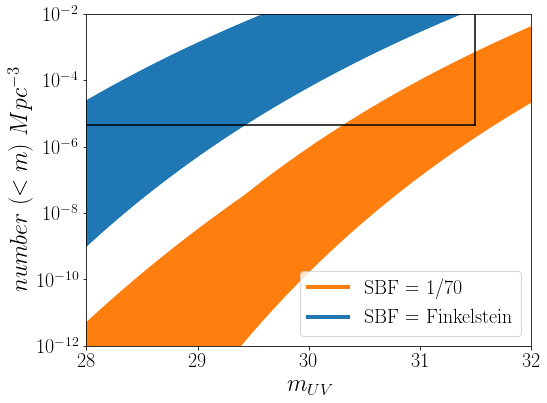

In [4]:
plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})

colors = ["C1","C0", "C0", "C0"]
i = 0

# For each stellar baryon fraction and HMF model plot luminosity function
for sbf in sbf_vals:
    first = True
    for quants, h, l in functional.get_hmf(['dndm','m'],z=z,Mmin=mmin,Mmax=mmax, hmf_model=fitting_models):
            if not first:
                nold = n
            mass_func = h.dndm
            mass = h.m
            n = hmf.integrate_hmf.hmf_integral_gtm(mass, mass_func)

            little_h = h.cosmo_model.h
            mass = mass * little_h
            n = n / little_h**3

            stellar_mass = mass * sbf
            
            # Extrapolation of M*-MUV relation from Song 2016 to z = 15
            M_vals = [-2.*(1.8 + np.log10(stellar_mass)), -2.*(1.6 + np.log10(stellar_mass)), \
                      -2.*(2. + np.log10(stellar_mass))]
            
            for M in M_vals:
                m = M + cosmo.distmod(z).value+ shift
                if first:
                    plt.plot(m, n, color = colors[i], rasterized = True)
                else:
                    plt.fill_between(m, n, nold, color = colors[i], rasterized = True)
            first = False
    i+=1
    
plt.yscale("Log")
plt.xlabel(r'$m_{UV}$', fontsize = 24);
plt.ylabel(r"$number \ (< m) \ Mpc^{-3}$", fontsize = 24);

# Visible bounds for JWST
# High enough magnitude and number density
xl = 28
xu = 32
yl = 10**-12
yu = 10**-2

plt.xlim(xl, xu)
plt.ylim(yl, yu)

# Plot box indicating visible points
plt.axhline(y = nmin, color = 'k', xmin = 0, xmax = (ABmax - xl)/(xu-xl))
plt.axvline(x = ABmax, color = 'k', ymin = (np.log10(nmin)-np.log10(yl))/(np.log10(yu)-np.log10(yl)), ymax = 1)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="C1", lw=4),Line2D([0], [0], color="C0", lw=4)]
plt.legend(custom_lines, ['SBF = 1/70', 'SBF = Finkelstein'])

plt.tight_layout()

plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.savefig("HF1600.pdf")